In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

Removed 0 outliers based on aspect ratio.


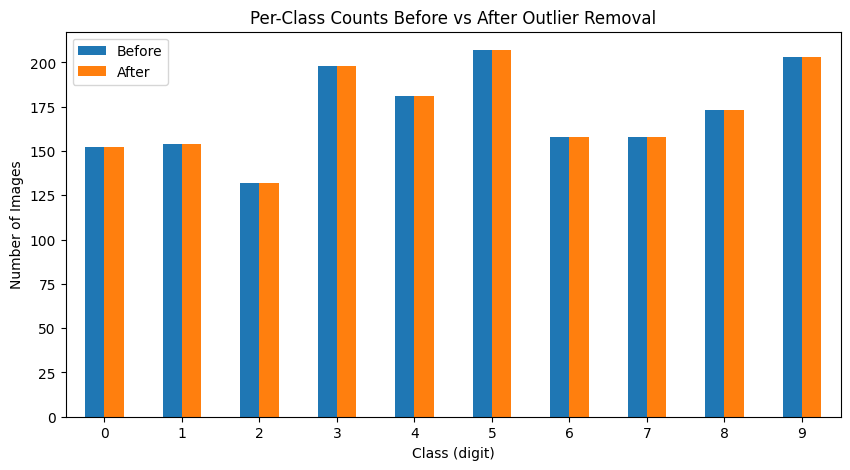

✅ Saved refined summary with outlier removal at: workspace\preprocess_summary.json


{'final_total': 1716,
 'final_split_counts': {'train': 1372, 'val': 172, 'test': 172},
 'final_per_class': {0: 152,
  1: 154,
  2: 132,
  3: 198,
  4: 181,
  5: 207,
  6: 158,
  7: 158,
  8: 173,
  9: 203}}

In [44]:
# --- Outlier Removal + Sanity Summary ---
import os, json
import pandas as pd
import matplotlib.pyplot as plt

# Load final split CSVs
train_df = pd.read_csv(SPLITS/"train.csv")
val_df   = pd.read_csv(SPLITS/"val.csv")
test_df  = pd.read_csv(SPLITS/"test.csv")

# Merge into one clean dataframe
clean_df = pd.concat([
    train_df.assign(split="train"),
    val_df.assign(split="val"),
    test_df.assign(split="test")
], ignore_index=True)

# --- Step 1: Outlier detection by image size ---
def get_image_size(path):
    try:
        import cv2
        img = cv2.imread(path)
        if img is None: 
            return None
        return img.shape[0], img.shape[1]  # (H, W)
    except:
        return None

clean_df["size"] = clean_df["path"].apply(get_image_size)

# Drop rows where size could not be read
before_count = len(clean_df)
clean_df = clean_df.dropna(subset=["size"]).reset_index(drop=True)

# Extract aspect ratio
clean_df["aspect_ratio"] = clean_df["size"].apply(lambda s: s[1]/s[0] if s else None)

# Define outlier rule (filter extreme aspect ratios)
before_counts = clean_df['cls'].value_counts().sort_index()
clean_df = clean_df[(clean_df["aspect_ratio"] > 0.5) & (clean_df["aspect_ratio"] < 2.0)]
after_counts = clean_df['cls'].value_counts().sort_index()

print(f"Removed {before_count - len(clean_df)} outliers based on aspect ratio.")

# --- Step 2: EDA Visualization ---
df_counts = pd.DataFrame({"Before": before_counts, "After": after_counts})
df_counts.plot(kind="bar", figsize=(10,5))
plt.title("Per-Class Counts Before vs After Outlier Removal")
plt.xlabel("Class (digit)")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

# --- Step 3: Save Summary JSON ---
summary = {
    "final_total" : int(len(clean_df)),
    "final_split_counts" : {
        "train": int((clean_df["split"]=="train").sum()),
        "val"  : int((clean_df["split"]=="val").sum()),
        "test" : int((clean_df["split"]=="test").sum())
    },
    "final_per_class" : {int(k): int(v) for k, v in clean_df["cls"].value_counts().sort_index().to_dict().items()}
}

out_json = WORK/"preprocess_summary.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("✅ Saved refined summary with outlier removal at:", out_json)
summary


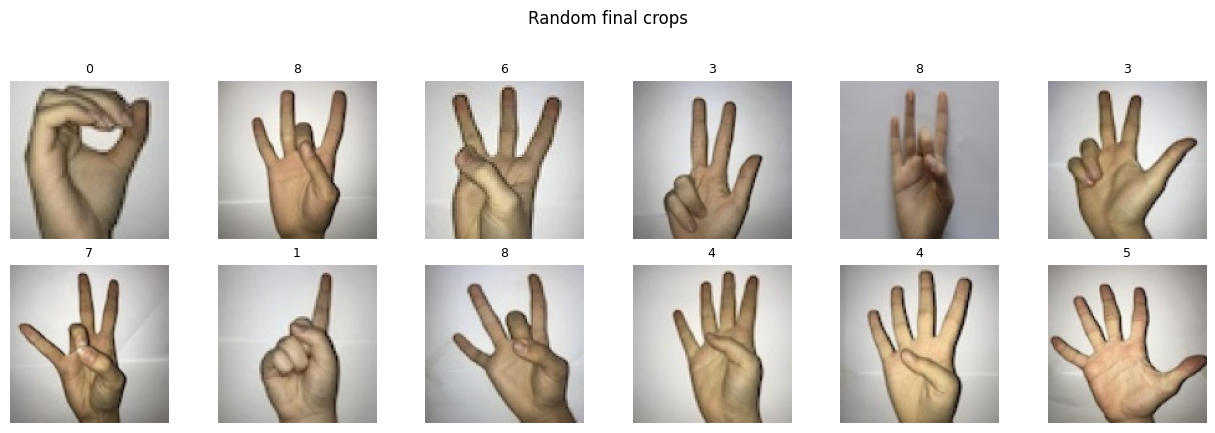

In [29]:
from pathlib import Path
import random, cv2

def show_random_crops(crops_dir, n=12, cols=6):
    """crops_dir = WORK/'crops_128' (created in your pipeline)"""
    paths = list(Path(crops_dir).rglob("*.jpg")) + list(Path(crops_dir).rglob("*.png"))
    if len(paths) == 0:
        print("No crops found at:", crops_dir); return
    random.shuffle(paths)
    paths = paths[:n]

    rows = (n + cols - 1)//cols
    plt.figure(figsize=(cols*2.1, rows*2.1))
    for i, p in enumerate(paths, 1):
        bgr = cv2.imread(str(p))
        if bgr is None: continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(rgb); plt.axis('off')
        plt.title(p.parent.name, fontsize=9)  # folder name = class
    plt.suptitle('Random final crops', y=1.02); plt.tight_layout(); plt.show()

show_random_crops(CROPS_DIR, n=12, cols=6)
